In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Task 2

**Finding feature with maximum correlation to SP500.**

In [2]:
df = pd.read_csv('sp500.csv')
corr = df.corr()
corr = dict(corr['SP500'])
del corr['SP500']
max_corr = [key for (key, val) in corr.items() if val == max(corr.values())][0]

**Function to prepare the dataset:**

In [3]:
def prepare_time_series(feature_name, df, time_samples=9, split_index=5):
    assert time_samples > split_index
    col = df[feature_name]
    df = pd.concat([col]*time_samples, axis=1)
    idx = ['T' + str(i) for i in range(time_samples)]
    df.columns = idx 
    for i in range(time_samples):
        df[idx[i]] = df[idx[i]].shift(-i)
    df = df.dropna()
    X = np.array(df[idx[:split_index]])
    y = np.array(df[idx[split_index:]])
    return X, y
        

**Normalize dataset and split into testing and training.**

In [4]:
X, y = prepare_time_series(max_corr, df)
scalerX = StandardScaler().fit(X)
scalerY = StandardScaler().fit(y)
X = scalerX.transform(X)
y = scalerY.transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Regression neural network, with 2 layers one with 5 nodes and another with 3. 
Adaptive solver, using an initial learning rate of 0.005 and early stopping to avoid over-fitting.**

In [6]:
reg = MLPRegressor(hidden_layer_sizes=(5, 3), solver='adam', learning_rate_init=0.005, early_stopping=True)
reg.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(5, 3), learning_rate='constant',
       learning_rate_init=0.005, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [7]:
y_predict = reg.predict(X_test)
mse = metrics.mean_squared_error(y_predict, y_test)
print(mse)

0.009281079773266823


**Denormalizing the data to reflect actual stock values.**

In [8]:
y_predict = scalerY.inverse_transform(y_predict)
y_test = scalerY.inverse_transform(y_test)

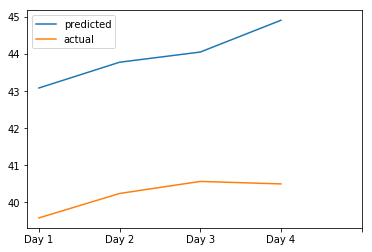

In [9]:
plt.plot(y_predict[50], label='predicted')
plt.plot(y_test[50], label='actual')
plt.xticks([0, 1, 2, 3, 4], ['Day 1', 'Day 2', 'Day 3', 'Day 4'])
plt.legend()
plt.show()

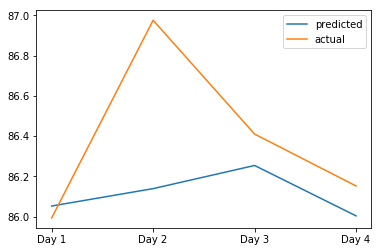

In [10]:
plt.plot(y_predict[150], label='predicted')
plt.plot(y_test[150], label='actual')
plt.xticks([0, 1, 2, 3], ['Day 1', 'Day 2', 'Day 3', 'Day 4'])
plt.legend()
plt.show()

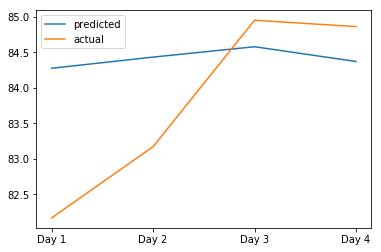

In [11]:
plt.plot(y_predict[250], label='predicted')
plt.plot(y_test[250], label='actual')
plt.xticks([0, 1, 2, 3], ['Day 1', 'Day 2', 'Day 3', 'Day 4'])
plt.legend()
plt.show()

# Task 3

In [1]:
import numpy as np
import pandas as pd
import json as js
import seaborn as sns
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [45]:
df = pd.read_json('reviews_Digital_Music_5.json', lines=True)
print(df.groupby(['overall']).size())

df1 = df[df['overall'] == 1].iloc[:2500]
df2 = df[df['overall'] == 2].iloc[:2500]
df3 = df[df['overall'] == 3].iloc[:2500]
df4 = df[df['overall'] == 4].iloc[:2500]
df5 = df[df['overall'] == 5].iloc[:2500]

df = df1.append(df2).append(df3).append(df4).append(df5)
df = df.sample(frac=1)

overall
1     2791
2     3010
3     6789
4    16536
5    35580
dtype: int64


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
7086,B00000252W,"[1, 1]",4,Even a mixed-bag Streisand album is still eons...,"05 1, 2008",A2VXQL36IFQGKZ,RALPH PETERS,CLASSIC TIME-CAPSULE CD,1209600000
51860,B000EGFV4K,"[4, 4]",1,I'm sorry but LL is just not the same as he wa...,"06 24, 2006",A398Z0ZU011ILU,Viper,Hang it up LL,1151107200
1567,B000000ORH,"[4, 6]",5,"I have Cher's whole discograaphy sience 1987, ...","03 31, 2003",AQ9XQBOAHB999,Javier Lopez,Cher's best album.,1049068800
6286,B000001Y61,"[0, 1]",4,If only music had stayed like this... botie ca...,"02 16, 2000",A118X8NUUAY0HG,poko loko,excellent,950659200
2155,B000000WZ4,"[1, 1]",5,"Long before this album appeared in april 1997,...","04 19, 1999",A2XB29P7XLLDBU,Oostrijck,My personal favourite,924480000
11163,B000002BSG,"[0, 1]",4,"Merge Stevie Wonder, Michael Jackson and The B...","07 10, 2003",A2UO10VW2BLHUM,Blackberries,Endearing,1057795200
5603,B000001FUB,"[11, 12]",4,If you've ever followed the P-Funk Earth Tour'...,"11 14, 2007",A192KEPM0HW6AC,"Interplanetary Funksmanship ""Swift lippin', e...","Triangulation, or, Fear of a Black Planet",1194998400
3639,B000001DUP,"[2, 2]",4,This was the album that got me into funk and g...,"08 2, 2005",A26NLSTT75FMJM,"finulanu ""&#34;the mysterious&#34;""",He is the Master.,1122940800
55037,B000UMQDHC,"[15, 22]",2,"I smell a Grammy, but not because it's a good ...","11 4, 2007",A3QC4SG7NA4ULG,A reader,Shake Me Wake Me When It Starts,1194134400
7667,B0000025CY,"[1, 2]",3,How about that- I was about ready to bash this...,"05 30, 2007",A2582KMXLK2P06,B. E Jackson,decent start,1180483200


In [11]:
X = np.array(df['reviewText'])
y = np.array(df['overall'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#You need to define X_train and X_test
tfidf_vectorizer = TfidfVectorizer(max_features=40000)
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

['Even a mixed-bag Streisand album is still eons better than most pop music and "ButterFly" is no exception. The song choice could be called \'eclectic\' at best and unfortunate at worst. There\'s certainly no quibbling about "Love in the Afternoon" or "Simple Man", which feature some of Barbra\'s loveliest singing. I\'ve always loved the sexy and playful "Guava Jelly", the gospel-tinged "Grandma\'s Hands" and "Crying Time" as well.  Okay, so David Bowie trounced her version of "Life on Mars"; I don\'t think it\'s all that bad, just a little melodramatic.  "I Won\'t Last A Day Without You" was a Carpenters hit and should have stayed just that--it\'s not that profound a love song and even Barbra can\'t alter those insipid lyrics. That leaves "Jubilation" (I like it); "Since I Don\'t Have You" (over-produced) and the innocuous "Let the Good Times Roll".  So, it\'s definitely worth buying but there\'s a reason why Jon Peters never solo-produced another Streisand album--he simply didn\'t g

In [30]:
mlp = MLPClassifier(hidden_layer_sizes=(1000, 512), solver='adam', learning_rate_init=0.001, early_stopping=True, verbose=True, max_iter=1000)

In [31]:
mlp.fit(X_train, y_train)

Iteration 1, loss = 1.19693579
Validation score: 0.607000
Iteration 2, loss = 0.39292439
Validation score: 0.572000
Iteration 3, loss = 0.07985986
Validation score: 0.568000
Iteration 4, loss = 0.01566309
Validation score: 0.570000
Iteration 5, loss = 0.00574878
Validation score: 0.575000
Iteration 6, loss = 0.00390836
Validation score: 0.578000
Iteration 7, loss = 0.00314662
Validation score: 0.578000
Iteration 8, loss = 0.00270780
Validation score: 0.580000
Iteration 9, loss = 0.00243410
Validation score: 0.584000
Iteration 10, loss = 0.00225358
Validation score: 0.577000
Iteration 11, loss = 0.00212793
Validation score: 0.578000
Iteration 12, loss = 0.00203924
Validation score: 0.576000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(1000, 512), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [32]:
y_predict = mlp.predict(X_test)

In [33]:
metrics.accuracy_score(y_test, y_predict)

0.6128

In [36]:
cm = metrics.confusion_matrix(y_test, y_predict)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm

array([[0.80638723, 0.11377246, 0.0499002 , 0.01796407, 0.01197605],
       [0.31325301, 0.40763052, 0.24899598, 0.02208835, 0.00803213],
       [0.04752852, 0.14828897, 0.5608365 , 0.20152091, 0.0418251 ],
       [0.0422833 , 0.02325581, 0.24312896, 0.52642706, 0.16490486],
       [0.03784861, 0.00199203, 0.03784861, 0.16334661, 0.75896414]])

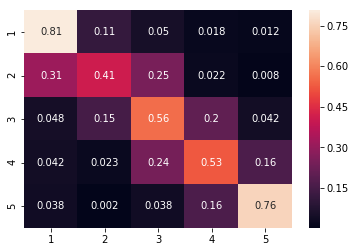

In [44]:
sns.heatmap(cm, annot=True, xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])

In [3]:
df = pd.read_json('reviews_Digital_Music_5.json', lines=True)
df.groupby(['overall']).size()

df1 = df[df['overall'] == 1].iloc[:2500]
df2 = df[df['overall'] == 2]
df3 = df[df['overall'] == 3].iloc[:4500]
df4 = df[df['overall'] == 4].iloc[:3500]
df5 = df[df['overall'] == 5].iloc[:2500]

df = df1.append(df2).append(df3).append(df4).append(df5)
print(df)
df = df.sample(frac=1)
X = np.array(df['reviewText'])
y = np.array(df['overall'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#You need to define X_train and X_test
tfidf_vectorizer = TfidfVectorizer(max_features=50000)
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

            asin   helpful  overall  \
30    B0000000ZW    [2, 9]        1   
86    B00000016W   [4, 29]        1   
94    B00000016W  [19, 24]        1   
95    B00000016W  [18, 73]        1   
167   B00000016W  [13, 65]        1   
382   B0000004VW   [3, 17]        1   
427   B0000004YH   [2, 17]        1   
690   B00000053X    [2, 8]        1   
695   B00000053X   [5, 17]        1   
696   B00000053X    [0, 1]        1   
700   B00000053X    [2, 7]        1   
807   B0000005XM   [5, 18]        1   
808   B0000005XM  [26, 66]        1   
938   B00000064G   [7, 58]        1   
1063  B0000009UW   [2, 19]        1   
1137  B000000EDW    [1, 4]        1   
1166  B000000HJO    [0, 4]        1   
1174  B000000HKV   [3, 24]        1   
1179  B000000HKV    [5, 6]        1   
1188  B000000HLL   [2, 12]        1   
1190  B000000HLL    [0, 5]        1   
1193  B000000HQ1   [5, 30]        1   
1335  B000000ISE    [7, 8]        1   
1348  B000000OB7   [1, 18]        1   
1453  B000000OPZ   [3, 30

In [5]:
mlp = MLPClassifier(hidden_layer_sizes=(1000, 512), solver='adam', learning_rate_init=0.001, early_stopping=True, verbose=True, max_iter=1000)

In [6]:
mlp.fit(X_train, y_train)
y_predict = mlp.predict(X_test)
metrics.accuracy_score(y_test, y_predict)

Iteration 1, loss = 1.19298163
Validation score: 0.597970
Iteration 2, loss = 0.43178235
Validation score: 0.601093
Iteration 3, loss = 0.09659716
Validation score: 0.590164
Iteration 4, loss = 0.02026558
Validation score: 0.572209
Iteration 5, loss = 0.00852578
Validation score: 0.576112
Iteration 6, loss = 0.00639805
Validation score: 0.571429
Iteration 7, loss = 0.00550678
Validation score: 0.580016
Iteration 8, loss = 0.00354875
Validation score: 0.576112
Iteration 9, loss = 0.00372179
Validation score: 0.574551
Iteration 10, loss = 0.00467328
Validation score: 0.566745
Iteration 11, loss = 0.00264251
Validation score: 0.568306
Iteration 12, loss = 0.00297267
Validation score: 0.564403
Iteration 13, loss = 0.00282964
Validation score: 0.569867
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


0.6008744534665834

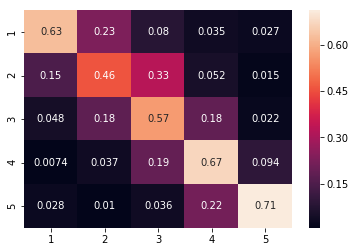

In [8]:
cm = metrics.confusion_matrix(y_test, y_predict)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])